In [3]:
# importing necessary libraries
import warnings
warnings.filterwarnings('ignore')

import random
random.seed(42)

import seaborn as sns
import pandas as pd
import numpy as np

from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit, cross_val_score

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

import matplotlib.pyplot as plt
%matplotlib inline


def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Считывание и подготовка данных

In [3]:
rates = pd.read_csv('new_prices.csv')
rates = rates.set_index('datetime')
rates.head()

,open,high,low,close
datetime,,,,
2018-01-02 00:02:00,66.67,66.69,66.67,66.69
2018-01-02 00:03:00,66.67,66.69,66.67,66.69
2018-01-02 00:04:00,66.68,66.70,66.67,66.69
2018-01-02 00:05:00,66.70,66.71,66.69,66.70
2018-01-02 00:06:00,66.71,66.72,66.70,66.71


In [4]:
def prepareData(data,minutes,lag_start=5, lag_end=14):
    '''Функция для введения лагов временного ряда'''
    
    data['y'] = data.close.shift(-minutes)
    data = data.dropna()
    
    # adding lags of original time series data as features
    for i in range(lag_start, lag_end):
        data["lag_{}".format(i)] = data.close.shift(i)
    data = data.dropna()
    return data
    


In [5]:
def split_data(data,start,middle,end):
    '''Функция для разделения ряда на три промежутка'''
    x_train = data[start:middle].drop(["y"], axis=1)
    y_train = data[start:middle]["y"]
    x_test = data[middle:end].drop(["y"], axis=1)
    y_test = data[middle:end]["y"]
    
    return x_train, y_train, x_test, y_test
    

In [6]:
minutes = 5
dd = prepareData(rates,minutes,lag_start=12, lag_end=48)

# Реализация метода скользящего окна
Окно равно 24 часам. Предсказания делаются на 5 минут вперед с шагом в 5 минут

In [7]:
from sklearn.linear_model import LinearRegression
from tqdm import tqdm

clf = LinearRegression()
prediction = pd.Series()
df = pd.DataFrame()

df['close'] = dd['2018-01-03':]['close']
times = df.shape[0]//minutes

In [10]:
start = 0
middle = 1044
end = 1049

for i in tqdm(range(times)):
    x_train,y_train,x_test,y_test = split_data(dd,start,middle,end)
    clf.fit(x_train,y_train)
    prediction = prediction.append(pd.Series(clf.predict(x_test)))
    
    start += 5
    middle += 5
    end += 5
    

100%|████████████████████████████████████████████████████████████████████████████| 92052/92052 [19:16<00:00, 79.58it/s]


In [11]:
df['predict'] = prediction.values

In [14]:
df.to_csv('timeseries.csv')

# Симуляция процесса торгов и визуализация результатов

In [30]:
df = pd.read_csv('test_timeseries.csv',parse_dates=[0])
df = df.set_index('datetime')

In [31]:
# Введение линии скользящей средней
s = 720
df['ema'] = df['close'].ewm(span=s).mean()

In [33]:
%run bot.ipynb

In [34]:
robot = bot(budget=1000,ema_thr=0.1,share = 0.8,thr=0.7)
df['trades'] = df.apply(lambda ts: robot.ticker(ts['close'],ts['predict'],ts['ema'],ts.name),axis=1)

print(robot)
print(robot.get_stat())

budget: 1009.206999999997 thr: 0.7
deals amount: 408
profitable: 96
unprofitable: 312
mean yield: 0.751
mean loss: -0.736


In [35]:
deals = robot.get_dataframe()

In [36]:
dealpoints = df['trades']
ratepoints = df['close']
emapoints = df['ema']

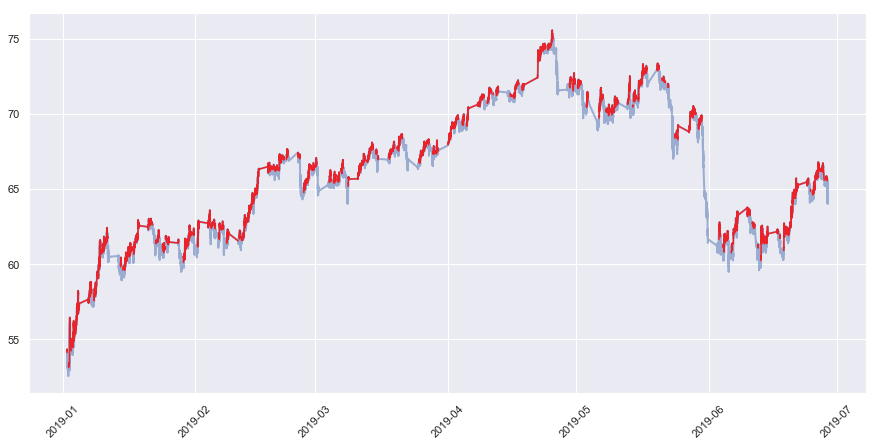

In [37]:
sns.set()
plt.figure(figsize=(15,7))
plt.xticks(rotation=30)

plt.plot(ratepoints, label="actual", linewidth=2.0,alpha=0.5, zorder=1)
plt.plot(dealpoints, c='red', alpha=0.8, zorder=2)
# plt.plot(emapoints, c='darkblue', alpha=0.8, zorder=2)
plt.xticks(rotation=45)

#plt.xlim('2018-09','2018-10')

plt.show()

In [38]:
profit = deals[deals['is_profitable'] == True]
unprofit = deals[deals['is_profitable'] == False]

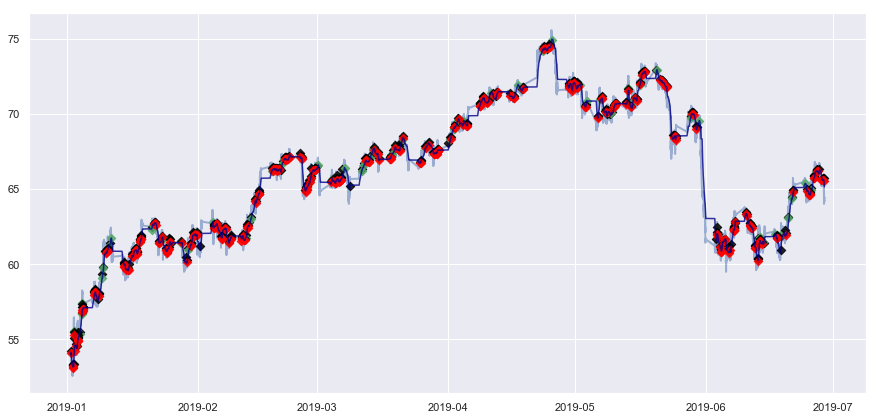

In [45]:
plt.figure(figsize=(15,7))

plt.plot(ratepoints, label="actual", linewidth=2.0,alpha=0.5, zorder=1)
plt.scatter(x=profit['opentime'],y=profit['openprice'],c='black',zorder=2, marker='D', alpha=0.85)
plt.scatter(x=profit['closetime'],y=profit['closeprice'],c='g',zorder=2, marker='D', alpha=0.85)

plt.scatter(x=unprofit['opentime'],y=unprofit['openprice'],c='black',zorder=2, marker='D', alpha=0.85)
plt.scatter(x=unprofit['closetime'],y=unprofit['closeprice'],c='red',zorder=2, marker='D', alpha=0.85)

plt.plot(emapoints, c='darkblue', alpha=0.8, zorder=2)
plt.show()